# `strategic-fl-sim`: Twitter/Sent140 Demo Experiment

Demonstrating strategic federated learning with Byzantine client who uses sign flipping

In [ ]:
import json
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from twitterdataset import TwitterDataset

from models.bert import BertWithClassifier
from strategicflsim.agents import Client, Server
from strategicflsim.utils.actions import create_scalar_action, create_sign_flip_action
from strategicflsim.utils.aggregation import get_aggregate
from strategicflsim.utils.evaluate import evaluate_with_ids
from strategicflsim.utils.metrics import get_gradient_metrics

/Users/dimitar-chakarov/Documents/projects/strategicfl/fl/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparation/initialization

### Setup device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # GPU
elif torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple M-series
else:
    device = torch.device("cpu")  # CPU

print(f"Using device: {device}")

Using device: mps


### Setup experiment configuration

In [17]:
config = {
    "training": {
        "T": 500,
        "lr": 0.06,
        "local_steps": 1,
        "batch_size": 8,
        "eval_batch_size": 8,
    },
    "clients": {
        "n_players": 5,
        "alpha_0": 1.0,
        "alpha_1": 2.0,
        "beta_0": 0.0,
        "beta_1": 0.0,
    },
    "aggregation": {"method": "mean"},
    "data": {
        "train_path": "../../data/twitter/train.json",
        "test_path": "../../data/twitter/test.json",
        "min_samples": 15,
        "max_samples": 20,
    },
    "model": {"max_length": 512},
}

print("Configuration:")
for section, values in config.items():
    print(f"  {section}:")
    for key, value in values.items():
        print(f"    {key}: {value}")

Configuration:
  training:
    T: 500
    lr: 0.06
    local_steps: 1
    batch_size: 8
    eval_batch_size: 8
  clients:
    n_players: 5
    alpha_0: 1.0
    alpha_1: 2.0
    beta_0: 0.0
    beta_1: 0.0
  aggregation:
    method: mean
  data:
    train_path: ../../data/twitter/train.json
    test_path: ../../data/twitter/test.json
    min_samples: 15
    max_samples: 20
  model:
    max_length: 512


### Helper function

In [18]:
def freeze_bert_encoder(model):
    """Freeze BERT encoder layers, keep only classifier trainable."""
    for name, param in model.named_parameters():
        if "classifier" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False


def get_data(path: str):
    """Load data from JSON file."""
    with open(path, "r") as f:
        data = json.load(f)
        user_names = data["users"]
        data_dict = data["user_data"]
    return data_dict, user_names


### Loading the Sent140 data

In [19]:
print("\nLoading Twitter data...")
data_dict, user_names = get_data(config["data"]["train_path"])
test_data_dict, user_names_test = get_data(config["data"]["test_path"])

print(f"Training data: {len(user_names)} users")
print(f"Test data: {len(user_names_test)} users")

# Verify consistency between train and test user names
usernames_diff = list(set(user_names) ^ set(user_names_test))
assert not usernames_diff, "Inconsistent usernames between test and train"

# DATA FILTERING
if "min_samples" in config["data"] and "max_samples" in config["data"]:
    subset = [
        user_name
        for user_name in user_names
        if config["data"]["min_samples"]
        <= len(data_dict[user_name]["y"])
        <= config["data"]["max_samples"]
    ]
    print(
        f"Filtered to {len(subset)} users with {config['data']['min_samples']}-{config['data']['max_samples']} samples"
    )

    user_names = subset
    data_dict = {key: data_dict[key] for key in subset}
    test_data_dict = {key: test_data_dict[key] for key in subset}


Loading Twitter data...
Training data: 254555 users
Test data: 254555 users
Filtered to 3415 users with 15-20 samples


### Creating a Server agent with BERT

In [20]:
print("\nCreating server...")
server_model = BertWithClassifier().to(device)

# Freeze BERT encoder, keep only classifier trainable
freeze_bert_encoder(server_model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in server_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in server_model.parameters())
print(
    f"Trainable parameters: {trainable_params:,} / {total_params:,} ({100 * trainable_params / total_params:.1f}%)"
)

server = Server(
    device=device,
    model=server_model,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.SGD(
        [p for p in server_model.parameters() if p.requires_grad],
        lr=config["training"]["lr"],
    ),
    aggregate_fn=get_aggregate(method=config["aggregation"]["method"]),
    agent_id="server",
)

print(f"Created server with {config['aggregation']['method']} aggregation")


Creating server...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 296,066 / 109,778,306 (0.3%)
Created server with mean aggregation


### Creating a group of Client agents

All but one clients are honest, one client is flipping the sign and scaling up the update.

In [ ]:
print("\nCreating clients...")
split_index = len(user_names) // config["clients"]["n_players"]
clients = []

for i in range(config["clients"]["n_players"]):
    start_idx = max(0, i * split_index)
    end_idx = min((i + 1) * split_index, len(user_names))
    client_user_names = user_names[start_idx:end_idx]

    if i == config["clients"]["n_players"] - 1:
        alpha = config["clients"]["alpha_1"]
        beta = config["clients"]["beta_1"]
        agent_id = "bad"
        print(
            f"  Client {i + 1}: BAD - {len(client_user_names)} users"
        )
        action = create_sign_flip_action(alpha)
    else:
        alpha = config["clients"]["alpha_0"]
        beta = config["clients"]["beta_0"]
        agent_id = f"good{i}"
        print(
            f"  Client {i + 1}: GOOD - {len(client_user_names)} users"
        )
        action = create_scalar_action(alpha, beta)

    train_dataset = TwitterDataset(
        client_user_names, data_dict, max_length=config["model"]["max_length"]
    )
    test_dataset = TwitterDataset(
        client_user_names, test_data_dict, max_length=config["model"]["max_length"]
    )

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config["training"]["batch_size"],
        shuffle=True,
        pin_memory=True if device.type == "cuda" else False,
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=config["training"]["eval_batch_size"],
        shuffle=False,
        pin_memory=True if device.type == "cuda" else False,
    )

    client_model = BertWithClassifier().to(device)
    freeze_bert_encoder(client_model)

    client = Client(
        device=device,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        model=client_model,
        criterion=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD(
            [p for p in client_model.parameters() if p.requires_grad],
            lr=config["training"]["lr"],
        ),
        action=action,
        agent_id=agent_id,
    )

    clients.append(client)


Creating clients...
  Client 1: honest (α=1.0, β=0.0) - 683 users


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 2: honest (α=1.0, β=0.0) - 683 users


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 3: honest (α=1.0, β=0.0) - 683 users


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 4: honest (α=1.0, β=0.0) - 683 users


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 5: ADVERSARIAL (α=2.0, β=0.0) - 683 users


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Run federated training

In [22]:
print(f"\nStarting federated training for {config['training']['T']} rounds...")

all_losses, all_metrics = server.train(
    clients=clients,
    T=config["training"]["T"],
    get_metrics=get_gradient_metrics,
)

print("Training completed!")


Starting federated training for 500 rounds...


Federated Training: 100%|██████████| 500/500 [15:25<00:00,  1.85s/it]

Training completed!


## Evaluate final performance

In [23]:
# This might be extremely slow if you're doing it locally, sorry :(

print("\nEvaluating final performance...")
final_accuracy, final_loss = evaluate_with_ids(server, clients)


Evaluating final performance...
good0: Accuracy = 0.5463, Loss = 0.6739
good1: Accuracy = 0.5450, Loss = 0.6741
good2: Accuracy = 0.5473, Loss = 0.6742
good3: Accuracy = 0.5519, Loss = 0.6708
bad: Accuracy = 0.5638, Loss = 0.6683


## Visualize training process

Figure saved as 'twitter_training_metrics.png'


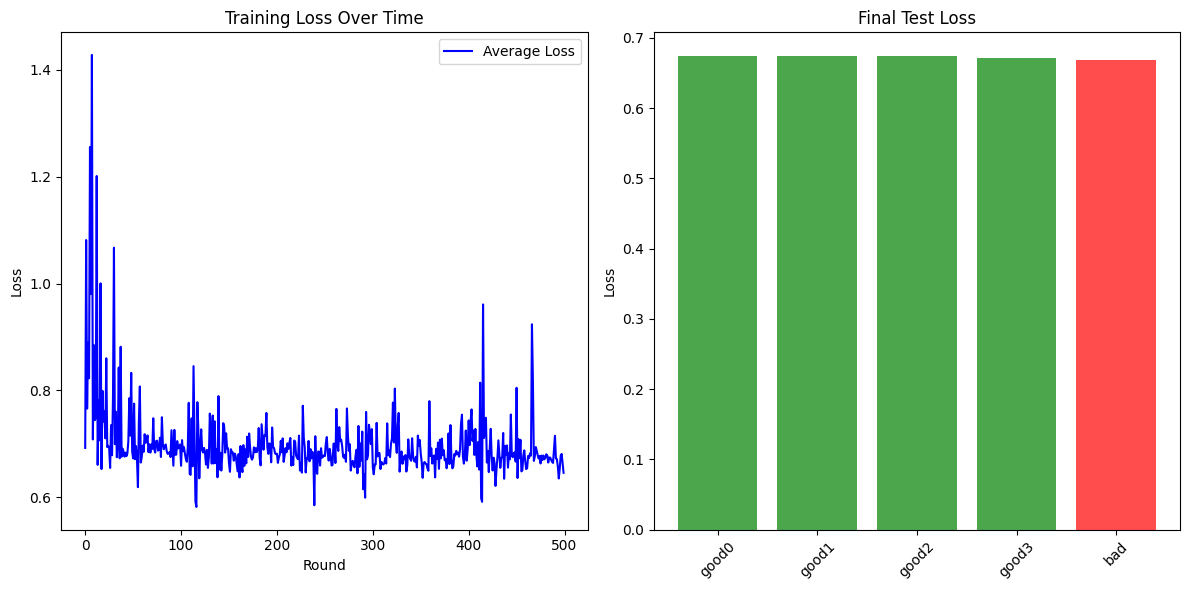

In [24]:
losses_array = np.array(
    [[loss for loss in round_losses] for round_losses in all_losses]
)
grad_norms_array = np.array([metrics["grad_norms"] for metrics in all_metrics])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Training losses over time
axes[0].plot(losses_array.mean(axis=1), label="Average Loss", color="blue")
# axes[0].fill_between(
#     range(len(losses_array)),
#     losses_array.min(axis=1),
#     losses_array.max(axis=1),
#     alpha=0.3,
#     color="blue",
# )
axes[0].set_title("Training Loss Over Time")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Loss")
axes[0].legend()

# # Individual client losses
# for i in range(config["clients"]["n_players"]):
#     client_type = (
#         "Adversarial" if i == config["clients"]["n_players"] - 1 else f"Honest {i + 1}"
#     )
#     axes[0, 1].plot(losses_array[:, i], label=client_type, alpha=0.7)
# axes[0, 1].set_title("Individual Client Losses")
# axes[0, 1].set_xlabel("Round")
# axes[0, 1].set_ylabel("Loss")
# axes[0, 1].legend()

# # Gradient norms
# for i in range(config["clients"]["n_players"]):
#     client_type = (
#         "Adversarial" if i == config["clients"]["n_players"] - 1 else f"Honest {i + 1}"
#     )
#     axes[1, 0].plot(grad_norms_array[:, i], label=client_type, alpha=0.7)
# axes[1, 0].set_title("Gradient Norms Over Time")
# axes[1, 0].set_xlabel("Round")
# axes[1, 0].set_ylabel("Gradient Norm")
# axes[1, 0].legend()

# Final loss bar plot
client_ids = list(final_loss.keys())
loss = [float(final_loss[client_id]) for client_id in client_ids]
colors = [
    "red"
    if "adversarial" in client_id.lower() or "bad" in client_id.lower()
    else "green"
    for client_id in client_ids
]
axes[1].bar(client_ids, loss, color=colors, alpha=0.7)
axes[1].set_title("Final Test Loss")
axes[1].set_ylabel("Loss")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()

# Save the figure to file
fig_filename = 'twitter_training_metrics'
plt.savefig(f'{fig_filename}.png', dpi=300, bbox_inches='tight')
print(f"Figure saved as '{fig_filename}.png'")

plt.show()

### Experiment summary

In [ ]:
print("\n" + "=" * 50)
print("EXPERIMENT SUMMARY")
print("=" * 50)
print("\nConfiguration:")
print(
    f"  Honest clients (a={config['clients']['alpha_0']}, b={config['clients']['beta_0']})"
)
print(
    f"  Adversarial client (a={config['clients']['alpha_1']}, b={config['clients']['beta_1']})"
)
print(f"  Training rounds: {config['training']['T']}")

print(f"\nFinal Results with {config['aggregation']['method']} aggregation:")
for client_id, acc in final_accuracy.items():
    loss = final_loss[client_id]
    acc_val = float(acc) if hasattr(acc, "item") else acc
    loss_val = float(loss) if hasattr(loss, "item") else loss
    print(f"  {client_id}: {acc_val:.4f} accuracy, {loss_val:.4f} loss")

# For the final comparison, get the adversarial client's performance
adversarial_acc = final_accuracy.get("bad", final_accuracy.get("adversarial"))
honest_accs = [
    final_accuracy[k]
    for k in final_accuracy.keys()
    if k != "bad" and k != "adversarial"
]

if adversarial_acc is not None and honest_accs:
    adversarial_val = (
        float(adversarial_acc) if hasattr(adversarial_acc, "item") else adversarial_acc
    )
    honest_vals = [float(acc) if hasattr(acc, "item") else acc for acc in honest_accs]

### [Optional] Saving the results

In [ ]:
results = {
    "config": config,
    "final_accuracy": final_accuracy,
    "final_loss": final_loss,
    "training_losses": losses_array,
    "gradient_norms": grad_norms_array,
}

with open("strategicflsim_demo_shakespeare.pkl", "wb") as f:
    pickle.dump(results, f)
print("Results saved to strategicflsim_demo_shakespeare.pkl")